In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [13]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
epoch_key = ('bon', 4, 2)

In [4]:
from src.parameters import ANIMALS as animals
from src.parameters import SAMPLING_FREQUENCY as sampling_frequency
from src.data_processing import (get_interpolated_position_dataframe,
                              get_LFP_dataframe,
                              get_mark_indicator_dataframe,
                              get_spike_indicator_dataframe,
                              make_neuron_dataframe,
                              make_tetrode_dataframe, reshape_to_segments,
                              save_xarray)
from src.ripple_detection.detectors import Karlsson_ripple_detector

tetrode_info = (
    make_tetrode_dataframe(animals)
    .loc[epoch_key]
    .set_index(['animal', 'day', 'epoch', 'tetrode_number'],
               drop=False))
# Get cell-layer CA1, iCA1 LFPs
is_hippocampal = (tetrode_info.area.isin(['CA1', 'iCA1', 'CA3']) &
                  (tetrode_info.descrip.isin(['riptet']) |
                   tetrode_info.validripple)
                  )
tetrode_keys = tetrode_info[is_hippocampal].index.tolist()
hippocampus_lfps = pd.concat(
    [get_LFP_dataframe(tetrode_key, animals)
     for tetrode_key in tetrode_keys], axis=1)
speed = get_interpolated_position_dataframe(
    epoch_key, animals).speed.values
time = hippocampus_lfps.index.values

In [5]:
ripple_times = Karlsson_ripple_detector(
        time, hippocampus_lfps.values, speed, sampling_frequency)
ripple_times

,start_time,end_time
1,2465.992033,2466.051367
2,2470.606800,2470.693467
3,2472.478133,2472.573467
4,2475.686800,2475.717467
5,2480.062133,2480.124800
6,2480.884800,2480.948800
7,2483.436133,2483.514800
8,2483.536133,2483.565467
9,2483.594800,2483.640800
10,2484.074133,2484.214800


In [6]:
ripple_times.loc[(ripple_times.start_time > 2790) & (ripple_times.start_time < 2792)]

,start_time,end_time
93,2790.727467,2791.128033


In [7]:
ripple_times.loc[(ripple_times.start_time > 2570) & (ripple_times.start_time < 2571)]

,start_time,end_time
32,2570.0668,2570.256133


In [8]:
ripple_times.loc[(ripple_times.start_time > 2947.9) & (ripple_times.start_time < 2948.2)]

,start_time,end_time
133,2947.949467,2948.0988


In [9]:
ripple_times.loc[(ripple_times.start_time > 2585) & (ripple_times.start_time < 2586)]

,start_time,end_time
38,2585.181467,2585.426133


In [10]:
from src.data_processing import (get_interpolated_position_dataframe,
                              get_LFP_dataframe,
                              get_mark_indicator_dataframe,
                              get_spike_indicator_dataframe,
                              make_neuron_dataframe,
                              make_tetrode_dataframe, reshape_to_segments,
                              save_xarray)
from src.ripple_decoding import (combined_likelihood,
                              estimate_marked_encoding_model,
                              estimate_sorted_spike_encoding_model,
                              estimate_state_transition, get_bin_centers,
                              predict_state, set_initial_conditions)
from src.analysis import _get_place, _get_place_at_spike, _get_training_marks


n_place_bins=61
place_std_deviation=None
mark_std_deviation=20
mark_variables = ['channel_1_max', 'channel_2_max', 'channel_3_max',
                  'channel_4_max']
hippocampal_tetrodes = tetrode_info[
    is_hippocampal &
    ~tetrode_info.descrip.str.endswith('Ref').fillna(False) &
    ~tetrode_info.descrip.str.startswith('Ref').fillna(False)]

position_info = get_interpolated_position_dataframe(epoch_key, animals)

marks = [(get_mark_indicator_dataframe(tetrode_key, animals)
          .loc[:, mark_variables])
         for tetrode_key in hippocampal_tetrodes.index]
marks = [tetrode_marks for tetrode_marks in marks
         if (tetrode_marks.loc[position_info.speed > 4, :].dropna()
             .shape[0]) != 0]

train_position_info = position_info.query('speed > 4')

place = _get_place(train_position_info, place_measure='linear_position')
place_at_spike = [_get_place_at_spike(tetrode_marks,
                                      train_position_info, place_measure='linear_position')
                  for tetrode_marks in marks]
training_marks = [_get_training_marks(tetrode_marks,
                                      train_position_info,
                                      mark_variables)
                  for tetrode_marks in marks]

place_bin_edges = np.linspace(
    np.floor(position_info.linear_position.min()),
    np.ceil(position_info.linear_position.max()),
    n_place_bins + 1)
place_bin_centers = get_bin_centers(place_bin_edges)

if place_std_deviation is None:
    place_std_deviation = place_bin_edges[1] - place_bin_edges[0]
    
combined_likelihood_kwargs = estimate_marked_encoding_model(
    place_bin_centers, place, place_at_spike, training_marks,
    place_std_deviation=place_std_deviation,
    mark_std_deviation=mark_std_deviation)

state_transition = estimate_state_transition(
    train_position_info, place_bin_edges, sequence_compression_factor=33,
    place_measure='linear_position')

state_names = ['outbound_forward', 'outbound_reverse',
               'inbound_forward', 'inbound_reverse']
n_states = len(state_names)
initial_conditions = set_initial_conditions(
    place_bin_edges, place_bin_centers, n_states)
decoder_kwargs = dict(
    initial_conditions=initial_conditions,
    state_transition=state_transition,
    likelihood_function=combined_likelihood,
    likelihood_kwargs=combined_likelihood_kwargs
)

/usr3/graduate/edeno/.conda/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


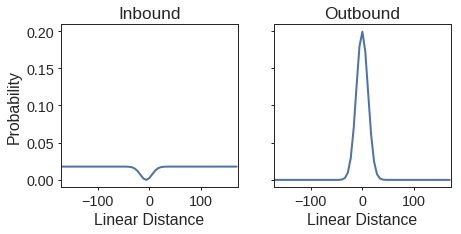

In [11]:
outbound_initial_conditions = initial_conditions[:n_place_bins]
inbound_initial_conditions = initial_conditions[n_place_bins+1:n_place_bins*2 + 1]

fig, ax = plt.subplots(1, 2, figsize=(7, 3), sharex=True, sharey=True)

ax[0].plot(place_bin_centers, inbound_initial_conditions * 4)
ax[0].set_ylabel('Probability')
ax[0].set_xlabel('Linear Distance')
ax[0].set_title('Inbound')
ax[0].set_xlim((place_bin_edges.min(), place_bin_edges.max()))

ax[1].plot(place_bin_centers, outbound_initial_conditions * 4)
ax[1].set_xlabel('Linear Distance')
ax[1].set_title('Outbound')
ax[1].set_xlim((place_bin_edges.min(), place_bin_edges.max()));

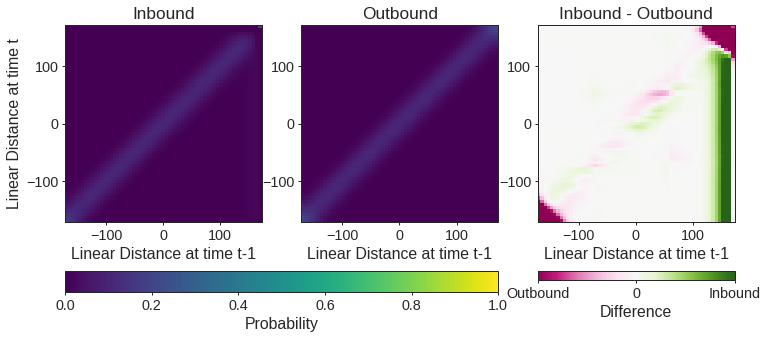

In [12]:
def plot_state_transition(state_transition, grid, ax=None,
                          vmin=0, vmax=1, cmap='viridis'):
    if ax is None:
        ax = plt.gca()
    x_grid, y_grid = np.meshgrid(grid, grid)
    mesh = ax.pcolormesh(x_grid, y_grid, state_transition,
                         cmap=cmap, vmin=vmin, vmax=vmax)
    grid_extent = (grid.min(), grid.max())
    ax.set_xlim(grid_extent)
    ax.set_ylim(grid_extent)
    ax.set_aspect('equal')
    return mesh


outbound_state_transitions = state_transition[:n_place_bins, :n_place_bins]
inbound_state_transitions = state_transition[n_place_bins+1:n_place_bins*2 + 1, n_place_bins+1:n_place_bins*2 + 1]
    
fig, ax = plt.subplots(1, 3, figsize=(12,6))

plot_state_transition(inbound_state_transitions, place_bin_edges, ax=ax[0])
ax[0].set_xlabel('Linear Distance at time t-1')
ax[0].set_ylabel('Linear Distance at time t')
ax[0].set_title('Inbound')

mesh1 = plot_state_transition(outbound_state_transitions, place_bin_edges, ax=ax[1])
ax[1].set_title('Outbound')
ax[1].set_xlabel('Linear Distance at time t-1')

state_transition_difference = inbound_state_transitions - outbound_state_transitions
mesh2 = plot_state_transition(state_transition_difference, place_bin_edges, ax=ax[2],
                              vmin=-0.01, vmax=0.01, cmap='PiYG')
ax[2].set_title('Inbound - Outbound')
ax[2].set_xlabel('Linear Distance at time t-1')

fig.colorbar(mesh1, ax=ax.ravel().tolist()[:2], label='Probability', orientation='horizontal')
cbar = fig.colorbar(mesh2, ax=ax[2], label='Difference', orientation='horizontal', ticks=[-0.01, 0, 0.01])
cbar.ax.set_xticklabels(['Outbound', '0', 'Inbound']);

In [14]:
from src.analysis import _get_ripple_marks
test_marks = _get_ripple_marks(
    marks, [(2790.730, 2791.069), (2570.073, 2570.246), (2947.943, 2948.179), (2585.179, 2585.421)], sampling_frequency)

In [15]:
posterior_density = [predict_state(ripple_marks, **decoder_kwargs)
                     for ripple_marks in test_marks]

In [16]:
n_ripples = len(test_marks)
posterior_density = xr.concat(
    [xr.DataArray(
        density.reshape((-1, n_states, place_bin_centers.size)),
        dims=['time', 'state', 'linear_position'],
        coords={
             'time': np.arange(density.shape[0]) / sampling_frequency,
             'linear_position': place_bin_centers,
             'state': state_names
        })
     for density in posterior_density],
    dim=pd.Index(np.arange(n_ripples) + 1, name='ripple_number'))
posterior_density

<xarray.DataArray (ripple_number: 4, time: 1018, state: 4, linear_position: 61)>
array([[[[  1.340364e-50, ...,   3.558856e-51],
         ..., 
         [  1.340364e-50, ...,   3.558856e-51]],

        ..., 
        [[  2.005043e-04, ...,   8.149957e-04],
         ..., 
         [  9.931739e-03, ...,   2.926349e-02]]],


       ..., 
       [[[  1.340364e-50, ...,   3.558856e-51],
         ..., 
         [  1.340364e-50, ...,   3.558856e-51]],

        ..., 
        [[           nan, ...,            nan],
         ..., 
         [           nan, ...,            nan]]]])
Coordinates:
  * time             (time) float64 0.0 0.0006667 0.001333 0.002 0.002667 ...
  * linear_position  (linear_position) float64 -169.2 -163.5 -157.9 -152.2 ...
  * state            (state) <U16 'outbound_forward' 'outbound_reverse' ...
  * ripple_number    (ripple_number) int64 1 2 3 4

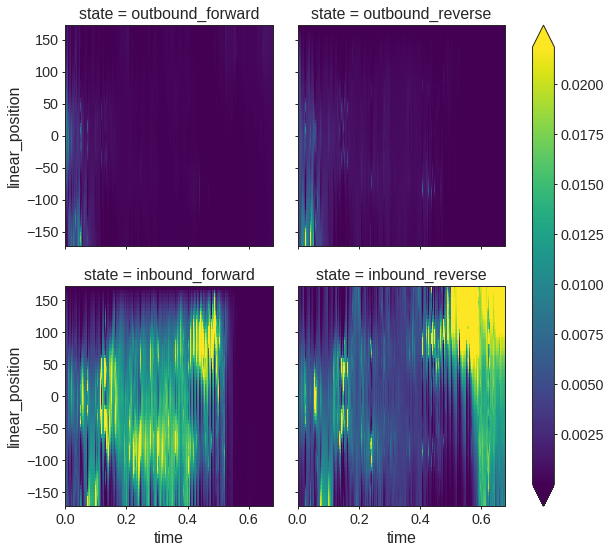

In [17]:
posterior_density.sel(ripple_number=1).dropna('time').plot(x='time', y='linear_position', col='state', robust=True, col_wrap=2, size=4);

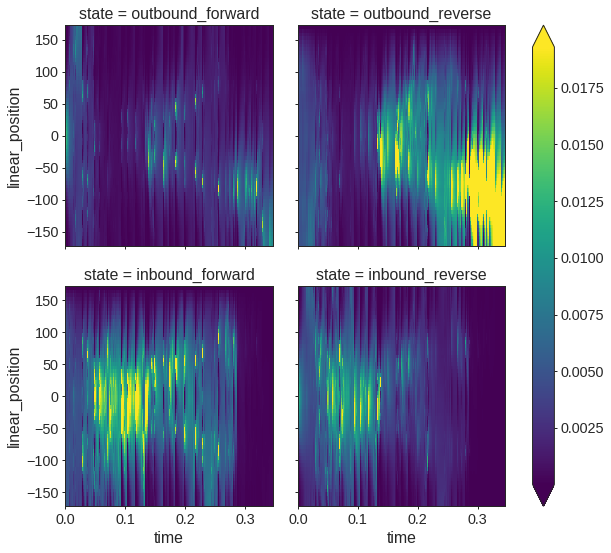

In [18]:
posterior_density.sel(ripple_number=2).dropna('time').plot(x='time', y='linear_position', col='state', robust=True, col_wrap=2, size=4);

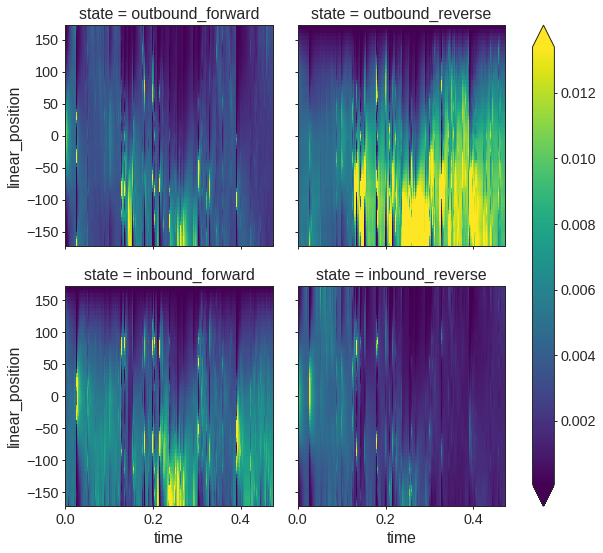

In [19]:
posterior_density.sel(ripple_number=3).dropna('time').plot(x='time', y='linear_position', col='state', robust=True, col_wrap=2, size=4);

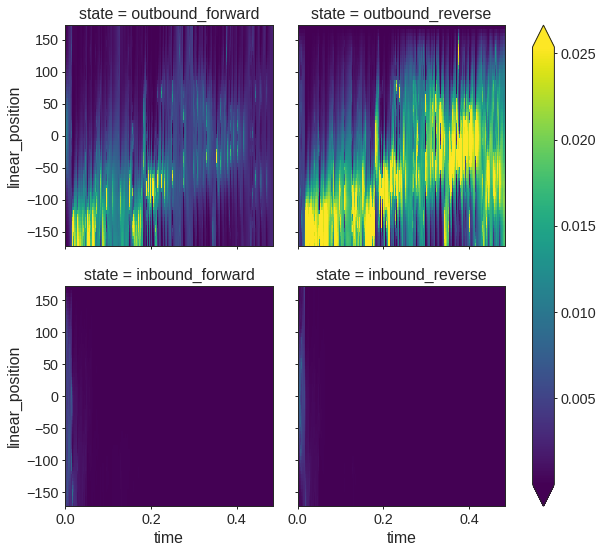

In [20]:
posterior_density.sel(ripple_number=4).dropna('time').plot(x='time', y='linear_position', col='state', robust=True, col_wrap=2, size=4);

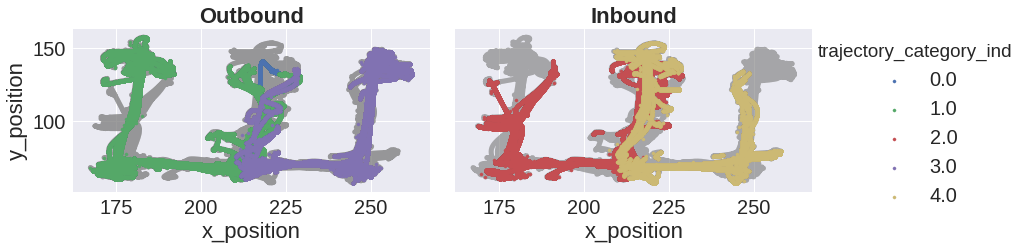

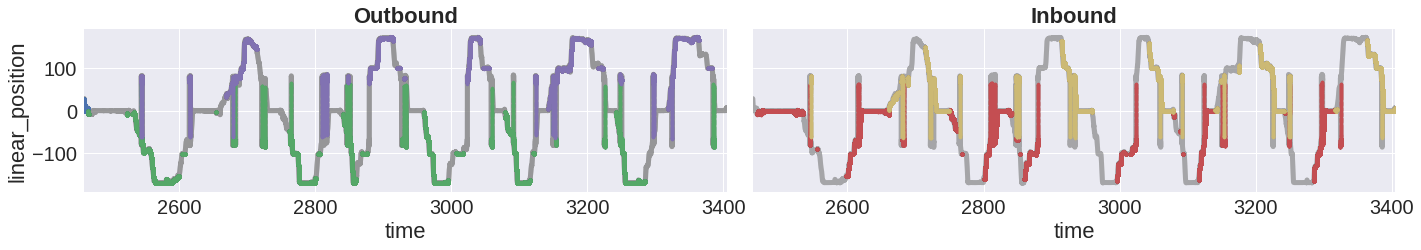

In [99]:
def scatter_wrap(x, y, df, **kwargs):
    data = kwargs.pop('data')
    ax = plt.gca()
    ax.plot(df[x], df[y], color='grey', zorder=1, linewidth=5, alpha=0.4)
    ax.scatter(data[x], data[y], **kwargs, zorder=2, s=10)

sns.set(font_scale=2)
grid = sns.FacetGrid(position_info, col='trajectory_direction',
                     hue='trajectory_category_ind', size=4, aspect=1.5)
grid.map_dataframe(scatter_wrap, 'x_position', 'y_position', position_info)
grid.set_titles(col_template="{col_name}", fontweight='bold', fontsize=18)
grid.add_legend()

grid = sns.FacetGrid(position_info.reset_index(), col='trajectory_direction',
                     hue='trajectory_category_ind', size=4, aspect=2.5)
grid.map_dataframe(scatter_wrap, 'time', 'linear_position', position_info.reset_index())
grid.set(xlim=(position_info.index.min(), position_info.index.max()))
grid.set_titles(col_template="{col_name}", fontweight='bold', fontsize=18)